In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote_auto.csv')
print("df_under is the oversample data frame\n", data.rate.value_counts().sort_index())

df_under is the oversample data frame
 1    261
2    261
3    261
4    261
5    261
Name: rate, dtype: int64


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class Knn (KNNBasic):
    def __init__(self, sim_options={}, bsl_options={}):
        KNNBasic.__init__(self, sim_options=sim_options, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)

    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNBasic.fit(self, trainset_fold)
            train_prediction = KNNBasic.test(self, trainset_fold.build_testset())
            prediction = KNNBasic.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNBasic.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## Knn SGD

* knn cosine, user based

In [4]:
knn = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn.create_reader(data)
predictions = knn.fit()
#acc
metrics = knn.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2578
RMSE: 0.6947
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2385
RMSE: 0.9071
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2322
RMSE: 0.8161
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2505
RMSE: 0.7692
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2389
RMSE: 0.8444
###############################################
The Results are: 

Average RMSE on Training Set: 0.24356079315595972
Average RMSE on Test Set: 0.8062982095233948
RMSE: 0.8038
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8037610207659106
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8038
MAE:  0.4839
MSE: 0.6460
Precision: 0.18
Recall: 0.14
the acc is 60.92


/tmp/ipykernel_5113/161991997.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [5]:
knn2 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn2.create_reader(data)
predictions = knn2.fit()
#acc
metrics = knn2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7318
RMSE: 0.9412
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7150
RMSE: 0.9027
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7086
RMSE: 0.9196
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7232
RMSE: 0.8832
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6964
RMSE: 0.9669
###############################################
The Results are: 

Average RMSE on Training Set: 0.7150170311754291
Average RMSE on Test Set: 0.9227103657206
RMSE: 0.8696
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8696283737839807
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8696
MAE:  0.6376
MSE: 0.7563
Precision: 0.12
Recall: 0.09
the acc is 54.41


/tmp/ipykernel_5113/3130600781.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3130600781.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [6]:
knn3 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn3.create_reader(data)
predictions = knn3.fit()
#acc
metrics = knn3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1431
RMSE: 0.7555
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1475
RMSE: 0.8205
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1263
RMSE: 0.8262
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1263
RMSE: 0.7927
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1442
RMSE: 0.7863
###############################################
The Results are: 

Average RMSE on Training Set: 0.13746925200186322
Average RMSE on Test Set: 0.7962277882290439
RMSE: 0.7230
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7229689901918495
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7230
MAE:  0.3821
MSE: 0.5227
Precision: 0.20
Recall: 0.15
the acc is 71.26


/tmp/ipykernel_5113/3369594395.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3369594395.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared diference, item based

In [7]:
knn4 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn4.create_reader(data)
predictions = knn4.fit()
#acc
metrics = knn4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3205
RMSE: 0.8397
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3099
RMSE: 0.7870
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3263
RMSE: 0.7717
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3252
RMSE: 0.7617
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3007
RMSE: 0.7666
###############################################
The Results are: 

Average RMSE on Training Set: 0.3165433902636974
Average RMSE on Test Set: 0.7853296567497025
RMSE: 0.7401
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7400949006984097
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7401
MAE:  0.4243
MSE: 0.5477
Precision: 0.18
Recall: 0.13
the acc is 70.11


/tmp/ipykernel_5113/1900242280.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/1900242280.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, user based

In [8]:
knn5 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn5.create_reader(data)
predictions = knn5.fit()
#acc
metrics = knn5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1207
RMSE: 0.7560
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1193
RMSE: 0.8243
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0669
RMSE: 0.6782
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1215
RMSE: 0.7908
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1183
RMSE: 0.8768
###############################################
The Results are: 

Average RMSE on Training Set: 0.10932986169011474
Average RMSE on Test Set: 0.7852060425228021
RMSE: 0.8560
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8559665832979908
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8560
MAE:  0.4973
MSE: 0.7327
Precision: 0.10
Recall: 0.07
the acc is 63.22


/tmp/ipykernel_5113/3339916766.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3339916766.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, item based

In [9]:
knn6 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn6.create_reader(data)
predictions = knn6.fit()
#acc
metrics = knn6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1235
RMSE: 0.7432
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0626
RMSE: 0.8817
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1166
RMSE: 0.7402
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1069
RMSE: 0.8768
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1263
RMSE: 0.7305
###############################################
The Results are: 

Average RMSE on Training Set: 0.10718033353078012
Average RMSE on Test Set: 0.7944657275719906
RMSE: 0.8536
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8536278152992778
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8536
MAE:  0.4966
MSE: 0.7287
Precision: 0.11
Recall: 0.08
the acc is 62.84


/tmp/ipykernel_5113/3614094042.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3614094042.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [10]:
knn7 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn7.create_reader(data)
predictions = knn7.fit()
#acc
metrics = knn7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1193
RMSE: 0.8972
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0532
RMSE: 0.8204
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1215
RMSE: 0.7716
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1197
RMSE: 0.8022
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0751
RMSE: 0.8384
###############################################
The Results are: 

Average RMSE on Training Set: 0.09776397361289371
Average RMSE on Test Set: 0.8259548855211396
RMSE: 0.7544
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7543908321025613
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_5113/3960392171.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3960392171.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [11]:
knn8 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn8.create_reader(data)
predictions = knn8.fit()
#acc
metrics = knn8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3965
RMSE: 0.7689
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4290
RMSE: 0.7833
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4024
RMSE: 0.7402
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.4084
RMSE: 0.9347
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3271
RMSE: 0.8633
###############################################
The Results are: 

Average RMSE on Training Set: 0.3926636979784662
Average RMSE on Test Set: 0.8180702019611461
RMSE: 0.8676
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8676112516089337
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_5113/3933834523.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3933834523.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## Knn Alternating Least Squares (ALS)

* knn cosine, user based

In [12]:
knn9 = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn9.create_reader(data)
predictions = knn9.fit()
#acc
metrics = knn9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2594
RMSE: 0.7965
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2536
RMSE: 0.8683
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2519
RMSE: 0.8132
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2537
RMSE: 0.8336
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2521
RMSE: 0.7769
###############################################
The Results are: 

Average RMSE on Training Set: 0.2541264779581299
Average RMSE on Test Set: 0.817679176263502
RMSE: 0.7700
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7700409387848152
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7700
MAE:  0.3988
MSE: 0.5930
Precision: 0.11
Recall: 0.07
the acc is 69.35


/tmp/ipykernel_5113/3513140556.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3513140556.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [13]:
knn10 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn10.create_reader(data)
predictions = knn10.fit()
#acc
metrics = knn10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7040
RMSE: 0.9820
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6875
RMSE: 0.9450
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7173
RMSE: 0.8360
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7174
RMSE: 0.9073
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7188
RMSE: 0.8625
###############################################
The Results are: 

Average RMSE on Training Set: 0.7089947912178843
Average RMSE on Test Set: 0.9065494748301584
RMSE: 0.9516
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9516072543743127
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9516
MAE:  0.6994
MSE: 0.9056
Precision: 0.11
Recall: 0.09
the acc is 48.28


/tmp/ipykernel_5113/857205367.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/857205367.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [14]:
knn11 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn11.create_reader(data)
predictions = knn11.fit()
#acc
metrics = knn11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1321
RMSE: 0.7814
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1362
RMSE: 0.7406
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1262
RMSE: 0.8211
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1410
RMSE: 0.8978
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1393
RMSE: 0.7032
###############################################
The Results are: 

Average RMSE on Training Set: 0.1349813860657412
Average RMSE on Test Set: 0.7888318324080894
RMSE: 0.8010
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8009729583138022
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8010
MAE:  0.4454
MSE: 0.6416
Precision: 0.10
Recall: 0.07
the acc is 64.75


/tmp/ipykernel_5113/1804258722.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/1804258722.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, item based

In [15]:
knn12 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn12.create_reader(data)
predictions = knn12.fit()
#acc
metrics = knn12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3204
RMSE: 0.7741
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2856
RMSE: 0.8307
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3059
RMSE: 0.8098
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3140
RMSE: 0.7949
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3205
RMSE: 0.7495
###############################################
The Results are: 

Average RMSE on Training Set: 0.30927265841657087
Average RMSE on Test Set: 0.791807609099536
RMSE: 0.7976
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7976356703078269
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7976
MAE:  0.5016
MSE: 0.6362
Precision: 0.14
Recall: 0.11
the acc is 65.13


/tmp/ipykernel_5113/262444695.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/262444695.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, user based

In [16]:
knn13 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn13.create_reader(data)
predictions = knn13.fit()
#acc
metrics = knn13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1487
RMSE: 0.7331
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0761
RMSE: 0.8511
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1393
RMSE: 0.7993
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1083
RMSE: 0.8118
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1214
RMSE: 0.8475
###############################################
The Results are: 

Average RMSE on Training Set: 0.11876083197396321
Average RMSE on Test Set: 0.8085565152713178
RMSE: 0.8606
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8605983102121455
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8606
MAE:  0.5147
MSE: 0.7406
Precision: 0.15
Recall: 0.08
the acc is 61.69


/tmp/ipykernel_5113/1092855449.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/1092855449.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, item based

In [17]:
knn14 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn14.create_reader(data)
predictions = knn14.fit()
#acc
metrics = knn14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1288
RMSE: 0.8077
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1492
RMSE: 0.7219
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0775
RMSE: 0.8457
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0640
RMSE: 0.8582
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1432
RMSE: 0.7891
###############################################
The Results are: 

Average RMSE on Training Set: 0.11253779692529645
Average RMSE on Test Set: 0.8045318810886604
RMSE: 0.7278
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7277934794692299
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.7278
MAE:  0.3806
MSE: 0.5297
Precision: 0.17
Recall: 0.11
the acc is 70.11


/tmp/ipykernel_5113/3580080987.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3580080987.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [18]:
knn15 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn15.create_reader(data)
predictions = knn15.fit()
#acc
metrics = knn15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0707
RMSE: 0.7553
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0958
RMSE: 0.8598
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0739
RMSE: 0.7617
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0874
RMSE: 0.7139
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0692
RMSE: 0.8296
###############################################
The Results are: 

Average RMSE on Training Set: 0.07940441457667491
Average RMSE on Test Set: 0.7840331100553384
RMSE: 0.7483
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7483283445669183
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_5113/3271800746.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3271800746.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [19]:
knn16 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn16.create_reader(data)
predictions = knn16.fit()
#acc
metrics = knn16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2667
RMSE: 0.7388
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2585
RMSE: 0.8663
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2903
RMSE: 0.7723
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2933
RMSE: 0.8112
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2638
RMSE: 0.8748
###############################################
The Results are: 

Average RMSE on Training Set: 0.2745210856891651
Average RMSE on Test Set: 0.8126595033251689
RMSE: 0.7759
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7758781679358625
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_5113/3154310150.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5113/3154310150.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
2,3,KnnBasic,MSD,SGD,True,0.722969,0.382054,0.522684,0.201149,0.145358,71.264368
13,14,KnnBasic,pearson corr coeff,ALS,False,0.727793,0.380640,0.529683,0.172414,0.109808,70.114943
3,4,KnnBasic,MSD,SGD,False,0.740095,0.424250,0.547740,0.178571,0.126028,70.114943
14,15,KnnBasic,(shrunk) pearson corr coeff,ALS,True,0.748328,0.395197,0.559995,0.147541,0.091283,67.816092
6,7,KnnBasic,(shrunk) pearson corr coeff,SGD,True,0.754391,0.401490,0.569106,0.166667,0.106860,68.965517
8,9,KnnBasic,Cosine,ALS,True,0.770041,0.398772,0.592963,0.109375,0.066572,69.348659
15,16,KnnBasic,(shrunk) pearson corr coeff,ALS,False,0.775878,0.456936,0.601987,0.120513,0.087500,61.685824
11,12,KnnBasic,MSD,ALS,False,0.797636,0.501647,0.636223,0.144608,0.106847,65.134100
10,11,KnnBasic,MSD,ALS,True,0.800973,0.445428,0.641558,0.100000,0.068929,64.750958
0,1,KnnBasic,Cosine,SGD,True,0.803761,0.483885,0.646032,0.176068,0.137002,60.919540


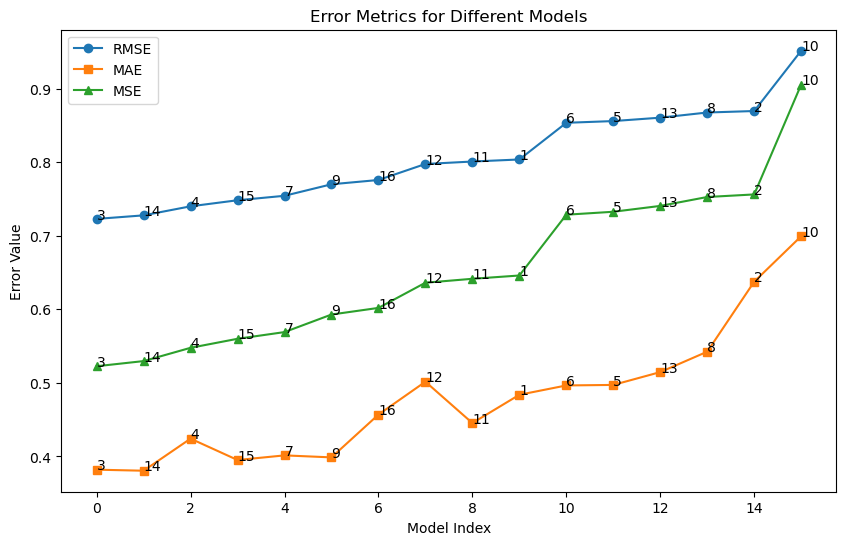

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

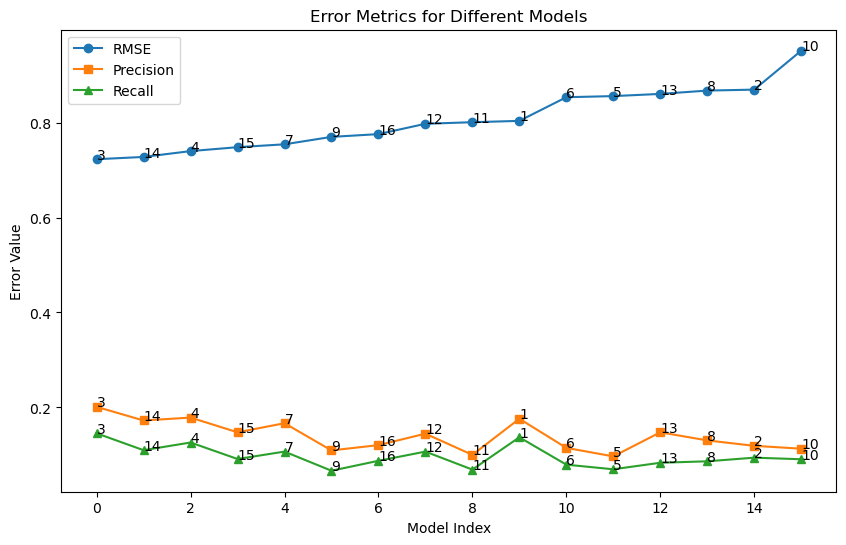

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

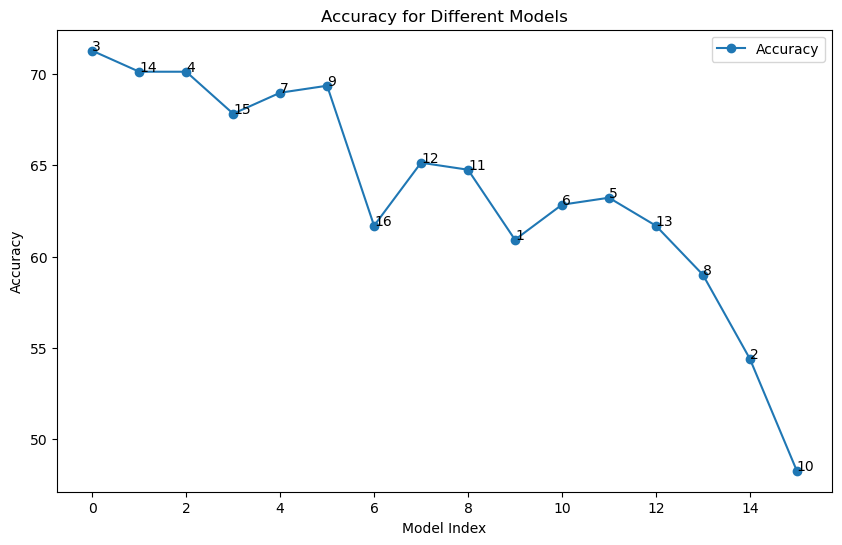

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
knn.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 0 with sim 1.000000000000000
user 0 with sim 1.000000000000000
user 0 with sim 1.000000000000000
user 0 with sim 1.000000000000000
user 0 with sim 1.000000000000000
And the baseline estimate is: 5.496469455380301

#####

Note: If the baseline is 2.962918660287081 then the value is a default value, Otherwise not


In [25]:
df_pred = knn.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,4ed273f7-1816-4f36-88c7-789125f011c7,2/5 大亂鬥 2,1.0,1.000000,"{'actual_k': 10, 'was_impossible': False}",13,111,0.000000
1,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Perlugo Extra Brut,4.0,3.000000,"{'was_impossible': True, 'reason': 'User and/o...",51,0,1.000000
2,00324bc3-0b35-4051-bc6d-9c258a4252c2,Cavalcaonte Barbera Forlí,5.0,5.000000,"{'actual_k': 23, 'was_impossible': False}",21,22,0.000000
3,ccdd1b9a-2056-4d76-b922-f427b7932ba7,Casa Rossa Rosso,4.0,3.000000,"{'was_impossible': True, 'reason': 'User and/o...",1,1,1.000000
4,5ccd8030-047b-432c-a630-d784ab415756,Acinaia,2.0,2.139869,"{'actual_k': 40, 'was_impossible': False}",78,22,0.139869
5,5ccd8030-047b-432c-a630-d784ab415756,The Society's Exhibition Shiraz,4.0,3.000000,"{'was_impossible': True, 'reason': 'User and/o...",78,1,1.000000
6,91cf68cc-9436-43e1-871d-33beef4d2337,Bella Cabernet Sauvignon,2.0,2.000000,"{'actual_k': 28, 'was_impossible': False}",35,25,0.000000
7,2a62eecd-b0cd-4395-9f8c-7c912a208be2,19 crimes dark red,5.0,4.944247,"{'actual_k': 37, 'was_impossible': False}",40,18,0.055753
8,bc79b0e3-064d-4240-86de-e86499f577e8,Paul Jaboulet Aine,3.0,3.000000,"{'was_impossible': True, 'reason': 'User and/o...",30,0,0.000000
9,b0fbc6bd-4b1e-48cd-92f3-f49b7a505941,Greco di Tufo Terre Degli Angeli,3.0,3.000000,"{'was_impossible': True, 'reason': 'User and/o...",4,1,0.000000


* best predictions

In [26]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
0,4ed273f7-1816-4f36-88c7-789125f011c7,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 10, 'was_impossible': False}",13,111,0.0
153,7ed7fb0c-884d-46bf-a14a-205474a0949d,Bordeaux blanc,3.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",2,1,0.0
154,9a3cc655-c88e-4c1b-95e2-add7579ff4c2,Amarone,3.0,3.0,"{'actual_k': 4, 'was_impossible': False}",5,8,0.0
155,014e4ed1-6f8b-4b25-917d-c167a2acca17,Bread & Butter Pinor Noir 2020,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",51,51,0.0
156,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Jurançon Sec,3.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",113,0,0.0
158,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Lagrein,3.0,3.0,"{'was_impossible': True, 'reason': 'Not enough...",51,3,0.0
161,2ca37f5d-ecd7-4194-9688-90c5ee6d3792,"Ionos, Roditis-SYrah",3.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",2,1,0.0
162,bc79b0e3-064d-4240-86de-e86499f577e8,"Chateau Grand Village, Bordeaux",3.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",30,1,0.0
152,014e4ed1-6f8b-4b25-917d-c167a2acca17,Bread & Butter Pinor Noir 2020,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",51,51,0.0
166,91cf68cc-9436-43e1-871d-33beef4d2337,Bella Cabernet Sauvignon,2.0,2.0,"{'actual_k': 28, 'was_impossible': False}",35,25,0.0


* worst predictions

In [27]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
26,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Organic pinot grigio terre siciliane igt,5.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",40,1,2.0
12,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il mattaglio brut,5.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",113,1,2.0
64,eadb1fb9-7260-4618-aa5a-8f2ebdca2077,Bread & Butter Pinor Noir 2020,1.0,3.0,"{'was_impossible': True, 'reason': 'Not enough...",2,51,2.0
146,bf82194f-6108-4524-9cef-69c0231ac74b,Nerello mascalese,1.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.0
134,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Reserva riesling estevez 2019,5.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",40,0,2.0
143,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Chateauneuf du pape,5.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",40,0,2.0
221,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Pinot noir provincial Di pavia rose,5.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",40,1,2.0
141,defee34b-7775-4889-b703-92b730d85e70,I Saltari Valpolicella Superiore,5.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",7,1,2.0
106,ce7409cd-2e73-490d-adee-95ed9e8d7b75,Aziano Chianti Classico,5.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.0
81,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Casillero del diabolo merlot Chile,5.0,3.0,"{'was_impossible': True, 'reason': 'User and/o...",40,1,2.0
